<a href="https://colab.research.google.com/github/bhaweshiitk/20.C51_project/blob/main/20_C51_Graduate_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
! pip install Bio
!pip install umap-learn
from Bio import SeqIO
import umap

In [2]:
# RNN, Hybrid RNN-CNN
# Linear regression, MLP, Random Forest
# Hyperparam tuning 
# Distance between train and test set

In [3]:
# Import data
! wget https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_annotations_v2.00.csv
! wget https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_database_v2.00.fasta

--2022-05-08 14:55:11--  https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_annotations_v2.00.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 948917 (927K) [text/plain]
Saving to: ‘megares_modified_annotations_v2.00.csv.1’

megares_modified_an 100%[===================>] 926.68K  --.-KB/s    in 0.04s   

2022-05-08 14:55:11 (24.8 MB/s) - ‘megares_modified_annotations_v2.00.csv.1’ saved [948917/948917]

--2022-05-08 14:55:11--  https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_database_v2.00.fasta
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.10

In [4]:
# Process data
train_annotations = pd.read_csv("./megares_modified_annotations_v2.00.csv")
train_annotations.shape

(7868, 5)

In [5]:
train_annotations.head()

,header,type,class,mechanism,group
0,MEG_1|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
1,MEG_2|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
2,MEG_3|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
3,MEG_4|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
4,MEG_5|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S


In [6]:
train_annotations['Seq_name'] = train_annotations['header'].str.split('|').str[0:2].apply('|'.join)
train_annotations['mechanism'] = train_annotations['header'].str.split('|').str[3]

In [7]:
fasta_sequences = SeqIO.parse(open("./megares_modified_database_v2.00.fasta"),'fasta')
sequence_dict = {}
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    name = "|".join((name.split("|", 2))[0:2])
    sequence_dict[name] = sequence
sequence_df = pd.DataFrame(sequence_dict.items(), columns=['Seq_name', 'Sequence'])
sequence_df.shape

(7868, 2)

In [8]:
sequence_df.head()

,Seq_name,Sequence
0,MEG_1|Drugs,AGAATTTGATCTTGGTTCAGATTGAACGCTGGCGGCGTGGATGAGG...
1,MEG_2|Drugs,AGGTAAGGAGGTGATCCAACCGCAGGTTCCCCTACGGTTACCTTGT...
2,MEG_3|Drugs,TTTTGTTTGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGC...
3,MEG_4|Drugs,AGAGATTGAACATAAGAGTTTGATCCTGGCTCAGATTGAACGCTGG...
4,MEG_5|Drugs,AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...


In [9]:
df = pd.merge(train_annotations[['Seq_name', 'type', 'class','mechanism','group']], 
              sequence_df, how = "inner", on = ["Seq_name"])
df.shape

(7868, 6)

In [10]:
df.head()

,Seq_name,type,class,mechanism,group,Sequence
0,MEG_1|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,AGAATTTGATCTTGGTTCAGATTGAACGCTGGCGGCGTGGATGAGG...
1,MEG_2|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,AGGTAAGGAGGTGATCCAACCGCAGGTTCCCCTACGGTTACCTTGT...
2,MEG_3|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,TTTTGTTTGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGC...
3,MEG_4|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,AGAGATTGAACATAAGAGTTTGATCCTGGCTCAGATTGAACGCTGG...
4,MEG_5|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...


In [11]:
df["class"].value_counts()

betalactams                                        3911
Aminoglycosides                                     773
Drug and biocide resistance                         363
Glycopeptides                                       299
Fluoroquinolones                                    296
Tetracyclines                                       294
MLS                                                 270
Multi-metal resistance                              226
Phenicol                                            145
Trimethoprim                                        135
Copper resistance                                   117
Multi-drug resistance                               113
Sulfonamides                                        103
Multi-biocide resistance                             98
Lipopeptides                                         95
Rifampin                                             70
Fosfomycin                                           62
Mercury resistance                              

In [12]:
df["mechanism"].value_counts()

Class_A_betalactamases                 1580
Class_C_betalactamases                  950
Class_D_betalactamases                  900
Class_B_betalactamases                  410
Aminoglycoside_N-acetyltransferases     359
                                       ... 
Tetracenomycin_MFS_efflux_pump            1
Tunicamycin_resistance_protein            1
Chromate_ABC_efflux_pump                  1
Biguanide_cation_efflux                   1
Sulfonamide_monooxygenase                 1
Name: mechanism, Length: 219, dtype: int64

In [13]:
# Label for prediction into major class of antibiotic resistance
label_1 = ['Aminoglycosides', 'betalactams', 'Glycopeptides', 'Tetracyclines', 'MLS', 'Fluoroquinolones', 'Trimethoprim',
           'Phenicol', 'Sulfonamides', 'Sulfonamides', 'Lipopeptides']

In [14]:
df['labels'] = df["class"]
df.loc[~df['labels'].isin(label_1),'labels'] = "other"

In [15]:
df.labels.value_counts()

betalactams         3911
other               1547
Aminoglycosides      773
Glycopeptides        299
Fluoroquinolones     296
Tetracyclines        294
MLS                  270
Phenicol             145
Trimethoprim         135
Sulfonamides         103
Lipopeptides          95
Name: labels, dtype: int64

In [16]:
X = df.Sequence.values
y = df.labels.values
print(X.shape, y.shape)
index_to_remove = []
for (i, seq) in enumerate(X):
  if set(seq.upper())!={"A", "T", "C", "G"}:
    index_to_remove.append(i)
index_to_remove
X = np.delete(X, index_to_remove, axis=0)
y = np.delete(y, index_to_remove, axis=0)
print(X.shape, y.shape)


(7868,) (7868,)
(7819,) (7819,)


In [17]:
code = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
label_code_1 = {"betalactams":0, "Aminoglycosides":1, "Glycopeptides":2, "Fluoroquinolones":3, "Tetracyclines":4, "MLS":5,
                 'Trimethoprim':6,'Phenicol':7,  'Sulfonamides':8, 'Lipopeptides':9,"other":10}

In [18]:

import torch.nn.functional as F

def encode(seq, label, labels_dict):
  label_int = labels_dict[label]
  enc_seq = [code[x] for x in seq.upper()]
  return [torch.LongTensor(enc_seq[0:2000]), torch.LongTensor([label_int]), len(enc_seq)]

class SequenceDataset(Dataset):
    def __init__(self, X, y, labels_dict):
        
        self.X = X 
        self.y = y 
        self.labels_dict =labels_dict
        self.len=len(self.X)      

    def __getitem__(self, index):
        # your implementation here: 
        X_elem, y_elem, length_seq = encode(self.X[index], self.y[index], labels_dict=self.labels_dict)
        return F.pad(X_elem, pad=(0, 2000 - len(X_elem))), y_elem

    def __len__(self):
        return self.len
    




In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 

In [20]:
train_data = SequenceDataset(X_train, y_train, labels_dict=label_code_1)
val_data = SequenceDataset(X_val, y_val, labels_dict=label_code_1)
test_data = SequenceDataset(X_test, y_test, labels_dict=label_code_1)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)# fill in code here
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)# fill in code here
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)# fill in code here

In [21]:
class cnn1d(nn.Module):
    def __init__(self, label_count = len(label_code_1)):
        super(cnn1d, self).__init__()
        self.embedding = nn.Embedding(5, 2*label_count)
        self.conv1 = nn.Conv1d(2*label_count, 64, kernel_size = 3, padding='same')
        self.maxpool1 = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool2 = nn.MaxPool1d(kernel_size=5)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool3 = nn.MaxPool1d(kernel_size=5)
        self.dense = nn.Sequential(nn.Linear(1024, 256), 
                             nn.ReLU(), nn.Linear(256, 64),
                             nn.ReLU(), nn.Linear(64, label_count))

    def forward(self, x):
        """Extract first fully connected feature vector"""
        # Apply convolutions
        x = self.embedding(x)
        x = self.conv1(x.permute(0, 2, 1))
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = torch.flatten(x, 1)
        x = self.dense(x)
        
        return x

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [23]:
model = cnn1d()
model = model.to(device)



In [24]:
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-3) 

In [25]:
def train(model, dataloader, optimizer, device):
    
    '''
    A function to train on the entire dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer): Optimizer object to interface gradient calculation and optimization 
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    batch_loss = []
    model.train() # Set model to training mode 
    train_loss = 0 
    count = 0
    for batch in dataloader:    
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        
        y_pred = model(seq)
        loss = nn.functional.cross_entropy(y_pred, label.squeeze())# fill in loss here
        train_loss += loss*len(label)
        count += len(label)
        batch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/count
    return np.array(batch_loss).mean(), train_loss.detach().cpu().numpy()


def validate(model, dataloader, device):
    
    '''
    A function to validate on the validation dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the validation data
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    
    batch_loss = []
    model.eval() # Set model to evaluation mode 
    val_loss = 0
    count = 0
    with torch.no_grad():    
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = nn.functional.cross_entropy(y_pred, label.squeeze())# fill in loss here
            val_loss += loss*len(label)
            count += len(label)
            batch_loss.append(loss.item())
            # validate your model on each batch here 
        val_loss = val_loss/count     
    return np.array(batch_loss).mean(), val_loss.detach().cpu().numpy()  

In [26]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(8):
    
    # Compute train your model on training data
    epoch_loss, train_loss = train(model, train_dataloader, optimizer,  device=0)
    
    # Validate your on validation data 
    _, val_loss = validate(model, val_dataloader, device=0) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    # The learning rate scheduler records the validation loss 
    # scheduler.step(val_loss)
    
    print(epoch, train_loss, val_loss)

epoch train loss validation loss
0 1.1783223 0.8729601
1 0.6927188 0.6199099
2 0.44892496 0.5067792
3 0.3117974 0.458027
4 0.18870743 0.38517708
5 0.1300639 0.47148457
6 0.07975096 0.47367504
7 0.05963558 0.4915492


In [27]:
pred_labels = []
true_labels = []
test_loss = 0
with torch.no_grad():
  model.eval()
  for batch in test_dataloader:
    seq, label = batch
    seq = seq.to(device)
    label = label.to(device)
    logits = model(seq)
    test_loss += nn.functional.cross_entropy(logits, label.squeeze())*len(label)
    preds = logits.max(1).indices
    true_labels.extend(list(label.squeeze().detach().cpu().numpy()))
    pred_labels.extend(list(preds.squeeze().detach().cpu().numpy()))
test_loss = test_loss/len(test_data)
test_acc = (np.array(true_labels) == np.array(pred_labels)).mean()
print("Test loss is {}".format(test_loss))
print("Test Acc is {}".format(test_acc))

Test loss is 0.4405617117881775
Test Acc is 0.9124040920716112


In [28]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(true_labels, pred_labels)
cmat

array([[792,   0,   2,   0,   0,   3,   0,   0,   0,   0,   7],
       [  1, 118,   0,   0,   0,   1,   0,   0,   1,   0,  12],
       [  8,   2,  39,   0,   0,   1,   0,   0,   0,   0,   7],
       [  0,   0,   0,  55,   0,   0,   0,   0,   0,   0,   4],
       [  1,   1,   0,   0,  43,   0,   0,   0,   0,   0,   6],
       [  3,   5,   0,   0,   0,  44,   0,   0,   0,   0,   8],
       [  0,   0,   0,   0,   0,   0,  27,   0,   0,   0,   4],
       [  0,   0,   0,   0,   0,   0,   0,  24,   0,   0,   4],
       [  0,   0,   0,   0,   0,   2,   0,   0,  15,   0,   2],
       [  1,   0,   1,   0,   0,   0,   0,   0,   0,   9,   2],
       [ 22,   8,   5,   0,   3,   8,   0,   1,   0,   1, 261]])

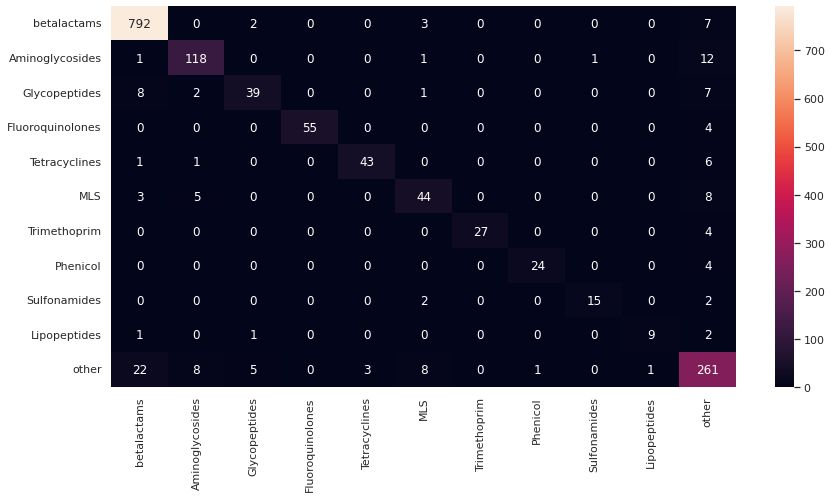

In [29]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(14,7)})

fig, ax = plt.subplots()
sns.heatmap(cmat, annot=cmat, fmt="",  ax=ax, yticklabels=(label_code_1.keys()),
            xticklabels=label_code_1.keys())
plt.show()

### Visualizing embeddings

In [32]:
model_cut = torch.nn.Sequential(*(list(model.children())[:-1]), model.dense[:-2])
model_cut

Sequential(
  (0): Embedding(5, 22)
  (1): Conv1d(22, 64, kernel_size=(3,), stride=(1,), padding=same)
  (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (6): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (7): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [33]:
# model_cut = nn.Sequential(*[model.children for i in range(1)])
# model_cut
embedding_list = []
label_list = []
model_cut.eval() # Set model to evaluation mode 
with torch.no_grad():    
    for batch in train_dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        seq = model_cut[0](seq)

        # print(x.shape)
        # Apply pooling
        seq = model_cut[1](seq.permute(0, 2, 1))
        seq = model_cut[2:7](seq)
        seq = torch.flatten(seq, 1)
        y_pred = model_cut[7](seq)
        label_list.extend(list(label.squeeze().detach().cpu().numpy()))
        embedding_list.extend(list(y_pred.detach().cpu().numpy()))
        
            # validate your model on each batch here

In [34]:
embedding_list = np.array(embedding_list)
label_list = np.array(label_list)
embedding_list.shape, label_list.shape

((5066, 64), (5066,))

In [35]:
label_value = [list(label_code_1.keys())[list(label_code_1.values()).index(p)] for p in label_list]

In [36]:
len(label_list), len(label_value)

(5066, 5066)

In [37]:
df_embedding = pd.DataFrame(data = (embedding_list))
# df_embedding["label"] = np.array(label_value)
df_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-6.570189,-6.938910,6.701191,0.519592,0.113458,15.246432,0.899276,0.248341,2.740855,-5.916751,...,-8.855597,-9.220138,1.936702,2.981421,6.924722,1.679513,-0.407779,-7.204693,0.186344,7.660814
1,-7.326131,-10.096955,1.229964,-10.138156,-0.610860,25.645634,17.795803,4.393361,-11.461280,-8.814661,...,-13.333885,-18.579546,-6.658008,-9.286631,0.290182,-10.290608,-12.356739,-9.379972,-3.623875,5.549961
2,-5.023946,5.817522,0.411452,-3.046355,1.885718,5.144278,-2.058549,4.662305,0.525668,-4.791907,...,-4.904459,-8.230456,5.817830,-4.801633,8.706628,6.401688,3.451042,-4.611625,2.950501,3.883005
3,-6.709077,-9.377768,0.251938,-14.813190,3.551131,20.382465,13.884812,8.516470,-8.059657,-8.575867,...,-9.692103,-16.122971,-4.962281,-4.701572,4.829715,-5.270295,-6.726505,-9.467527,-2.056803,4.280687
4,-7.836594,-10.756968,1.229354,-10.662532,-1.204538,28.377247,19.793093,3.853610,-12.558188,-9.858937,...,-14.861003,-19.080675,-6.259854,-8.925197,0.116949,-9.833127,-13.829207,-9.692881,-5.329885,6.516525


In [38]:
fit = umap.UMAP()
# Use default parameters?

In [39]:
reduced_embedding = fit.fit_transform(df_embedding)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [40]:
reduced_embedding = pd.DataFrame(reduced_embedding, columns=['dim1', 'dim2'])
reduced_embedding["label"] = np.array(label_value)

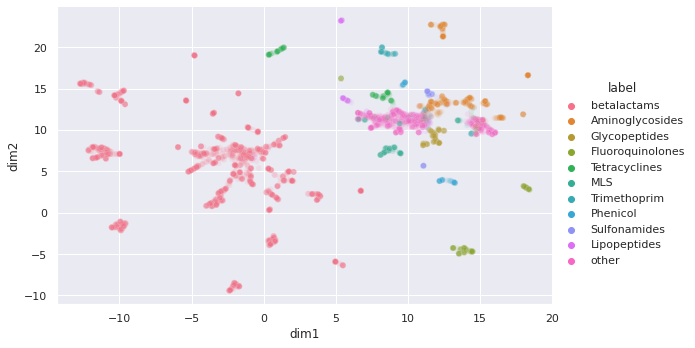

In [41]:
sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
                hue='label', hue_order=label_code_1.keys(), aspect=1.61, alpha = 0.1)
plt.show()

# Multitask Learning (Joint Class and Mechanism of Antibiotic Resistance Prediction)

In [42]:
# Creating mechanism label for known important antibiotic resistance mechanism
df["labels_2"] = "other"
df.loc[(df['mechanism'].str.contains("nucleotidyltransferases")),'labels_2'] = "nucleotidyltransferases"
df.loc[(df['mechanism'].str.contains("methyltransferases")),'labels_2'] = "methyltransferases"
df.loc[(df['mechanism'].str.contains("phosphotransferases")),'labels_2'] = "phosphotransferases"
df.loc[(df['mechanism'].str.contains("acetyltransferases")),'labels_2'] = "acetyltransferases"
df.loc[(df['mechanism'].str.contains("Quinolone_resistance_protein_Qnr")),'labels_2'] = "Quinolone_resistance_protein_Qnr"
df.loc[(df['mechanism'].str.contains("Dihydrofolate_reductase")),'labels_2'] = "Dihydrofolate_reductase"
df.loc[(df['mechanism'].str.contains("Tetracycline_resistance_ribosomal_protection_proteins")),
       'labels_2'] = "Tetracycline_resistance_ribosomal_protection_proteins"
df.loc[(df['mechanism'].str.contains("efflux_pump")),'labels_2'] = "efflux_pump"
df.loc[(df['mechanism'].str.contains("Fluoroquinolone-resistant_DNA_topoisomerases")),'labels_2'] = "Fluoroquinolone-resistant_DNA_topoisomerases"
df.loc[(df['mechanism'] == "Class_A_betalactamases"),'labels_2'] = "Class_A_betalactamases"
df.loc[(df['mechanism'] == "Class_B_betalactamases"),'labels_2'] = "Class_B_betalactamases"
df.loc[(df['mechanism'] == "Class_C_betalactamases"),'labels_2'] = "Class_C_betalactamases"
df.loc[(df['mechanism'] == "Class_D_betalactamases"),'labels_2'] = "Class_D_betalactamases"
label_code_2 = {}
labels_2 = ["nucleotidyltransferases", "methyltransferases", "phosphotransferases",
            "acetyltransferases", "Quinolone_resistance_protein_Qnr", "Dihydrofolate_reductase", "efflux_pump",
            "Tetracycline_resistance_ribosomal_protection_proteins", "Fluoroquinolone-resistant_DNA_topoisomerases",
            "Class_A_betalactamases", "Class_B_betalactamases", "Class_C_betalactamases","Class_D_betalactamases", "other"]
for (i, elem) in enumerate(labels_2):
  label_code_2[elem] = i

In [43]:
df.labels_2.value_counts()

other                                                    1642
Class_A_betalactamases                                   1580
Class_C_betalactamases                                    950
Class_D_betalactamases                                    900
efflux_pump                                               826
acetyltransferases                                        445
Class_B_betalactamases                                    410
nucleotidyltransferases                                   296
Quinolone_resistance_protein_Qnr                          173
methyltransferases                                        145
Dihydrofolate_reductase                                   135
Tetracycline_resistance_ribosomal_protection_proteins     134
phosphotransferases                                       122
Fluoroquinolone-resistant_DNA_topoisomerases              110
Name: labels_2, dtype: int64

In [44]:
X = df.Sequence.values
y = np.array([df.labels.values, df.labels_2.values]).transpose()
print(X.shape, y.shape)
index_to_remove = []
for (i, seq) in enumerate(X):
  if set(seq.upper())!={"A", "T", "C", "G"}:
    index_to_remove.append(i)
index_to_remove
X = np.delete(X, index_to_remove, axis=0)
y = np.delete(y, index_to_remove, axis=0)

print(X.shape,y.shape)

(7868,) (7868, 2)
(7819,) (7819, 2)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 

In [46]:
import torch.nn.functional as F

def encode_multitask(seq, label, labels_dict1, labels_dict2):
  label_int1 = labels_dict1[label[0]]
  label_int2 = labels_dict2[label[1]]
  enc_seq = [code[x] for x in seq.upper()]
  return [torch.LongTensor(enc_seq[0:2000]), torch.LongTensor([label_int1, label_int2]), len(enc_seq)]

class SequenceDatasetMultitask(Dataset):
    def __init__(self, X, y, labels_dict1, labels_dict2):
        
        self.X = X 
        self.y = y 
        self.labels_dict1 =labels_dict1
        self.labels_dict2 = labels_dict2
        self.len=len(self.X)      

    def __getitem__(self, index):
        # your implementation here: 
        X_elem, y_elem, length_seq = encode_multitask(self.X[index], self.y[index], 
                                                      labels_dict1=self.labels_dict1, labels_dict2 = self.labels_dict2)
        return F.pad(X_elem, pad=(0, 2000 - len(X_elem))), y_elem

    def __len__(self):
        return self.len
    




In [47]:

train_data = SequenceDatasetMultitask(X_train, y_train, labels_dict1 = label_code_1, labels_dict2 = label_code_2)
val_data = SequenceDatasetMultitask(X_val, y_val, labels_dict1 = label_code_1, labels_dict2 = label_code_2)
test_data = SequenceDatasetMultitask(X_test, y_test, labels_dict1 = label_code_1, labels_dict2 = label_code_2)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)# fill in code here
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)# fill in code here
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)# fill in code here

In [98]:
class cnn1d_multitask(nn.Module):
    def __init__(self, label_count1 = len(label_code_1), label_count2 = len(label_code_2)):
        super(cnn1d_multitask, self).__init__()
        count = 2*(label_count1+label_count2)
        self.embedding = nn.Embedding(5, count)
        self.conv1 = nn.Conv1d(count, 64, kernel_size = 3, padding='same')
        self.maxpool1 = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool2 = nn.MaxPool1d(kernel_size=5)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool3 = nn.MaxPool1d(kernel_size=5)
        self.dense1 = nn.Sequential(nn.Linear(1024, 256), 
                             nn.ReLU(), nn.Linear(256, 64),
                             nn.ReLU(), nn.Linear(64, label_count1))
        self.dense2 = nn.Sequential(nn.Linear(1024, 256), 
                             nn.ReLU(), nn.Linear(256, 64),
                             nn.ReLU(), nn.Linear(64, label_count2))

    def forward(self, x):
        """Extract first fully connected feature vector"""
        x = self.embedding(x)
        
        x = self.conv1(x.permute(0, 2, 1))
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = torch.flatten(x, 1)
        x1 = self.dense1(x)
        x2 = self.dense2(x)
        
        return x1, x2

In [99]:
model = cnn1d_multitask(label_count1=len(label_code_2), label_count2 = len(label_code_2))
model = model.to(device)

In [100]:
model

cnn1d_multitask(
  (embedding): Embedding(5, 56)
  (conv1): Conv1d(56, 64, kernel_size=(3,), stride=(1,), padding=same)
  (maxpool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (maxpool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (maxpool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (dense1): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=14, bias=True)
  )
  (dense2): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=14

In [101]:
def train_multitask(model, dataloader, optimizer, device):
    
    '''
    A function to train on the entire dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer): Optimizer object to interface gradient calculation and optimization 
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    batch_loss = []
    model.train() # Set model to training mode 
    train_loss = 0 
    count = 0
    for batch in dataloader:    
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        
        y_pred = model(seq)
        loss1 = nn.functional.cross_entropy(y_pred[0], label.squeeze()[:, 0])# fill in loss here
        loss2 = nn.functional.cross_entropy(y_pred[1], label.squeeze()[:, 1])
        loss = (loss1+loss2)/2
        train_loss += (loss)*len(label)
        count += len(label)
        batch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/count
    return np.array(batch_loss).mean(), train_loss.detach().cpu().numpy() 


def validate_multitask(model, dataloader, device):
    
    '''
    A function to validate on the validation dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the validation data
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    batch_loss = []
    val_loss = 0
    count = 0
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            
            loss1 = nn.functional.cross_entropy(y_pred[0], label.squeeze()[:, 0])# fill in loss here
            loss2 = nn.functional.cross_entropy(y_pred[1], label.squeeze()[:, 1])
            loss = (loss1+loss2)/2
            val_loss += loss*len(label)
            count += len(label)
            batch_loss.append(loss.item())
            # validate your model on each batch here 
        val_loss = val_loss/count     
    return np.array(batch_loss).mean(), val_loss.detach().cpu().numpy()    

In [102]:
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.5*1e-3) 

In [103]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(8):
    
    # Compute train your model on training data
    epoch_loss, train_loss = train_multitask(model, train_dataloader, optimizer,  device=device)
    
    # Validate your on validation data 
    epoch_loss , val_loss = validate_multitask(model, val_dataloader, device=device) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    # The learning rate scheduler records the validation loss 
    # scheduler.step(val_loss)
    
    print(epoch, train_loss, val_loss)

epoch train loss validation loss
0 1.3535036 1.0888348
1 0.90666944 0.69984233
2 0.57493836 0.54623854
3 0.40551355 0.4421415
4 0.2983366 0.3849027
5 0.21093532 0.41669536
6 0.14948368 0.4316474
7 0.10501544 0.40340993


In [97]:
pred_labels_class = []
pred_labels_mechanism = []
true_labels_class = []
true_labels_mechanism = []
test_loss = 0
with torch.no_grad():
  model.eval()
  for batch in test_dataloader:
    seq, label = batch
    seq = seq.to(device)
    label = label.to(device)
    logits = model(seq)
    loss1 = nn.functional.cross_entropy(logits[0], label.squeeze()[:, 0])# fill in loss here
    loss2 = nn.functional.cross_entropy(logits[1], label.squeeze()[:, 1])
    loss = (loss1+loss2)/2
    test_loss += loss*len(label)
    preds1 = logits[0].max(1).indices
    preds2 = logits[1].max(1).indices
    true_labels_class.extend(list(label.squeeze().detach().cpu().numpy()[:, 0]))
    true_labels_mechanism.extend(list(label.squeeze().detach().cpu().numpy()[:, 1]))

    pred_labels_class.extend(list(preds1.squeeze().detach().cpu().numpy()))
    pred_labels_mechanism.extend(list(preds2.squeeze().detach().cpu().numpy()))
test_loss = test_loss/len(test_data)
test_loss = test_loss.detach().cpu().numpy()
print("Test loss is {}".format(test_loss))
class_acc = (np.array(true_labels_class) ==  np.array(pred_labels_class)).mean()
mechanism_acc = (np.array(true_labels_mechanism) ==  np.array(pred_labels_mechanism)).mean()

print("Test Acc for Class Prediction is {}".format(class_acc))
print("Test Acc for Mechanism Prediction is {}".format(mechanism_acc))

Test loss is 0.40111440420150757
Test Acc for Class Prediction is 0.9085677749360613
Test Acc for Mechanism Prediction is 0.8849104859335039


In [55]:
cmat = confusion_matrix(true_labels_class, pred_labels_class)

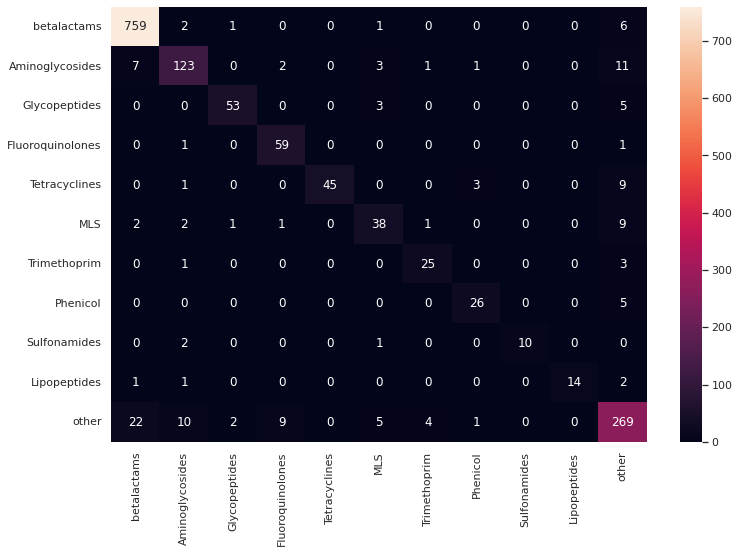

In [56]:
sns.set(rc = {'figure.figsize':(12,8)})
fig, ax = plt.subplots()
sns.heatmap(cmat, annot=cmat, fmt="",  ax=ax, yticklabels=(label_code_1.keys()),
            xticklabels=label_code_1.keys())
plt.show()

In [57]:
cmat = confusion_matrix(true_labels_mechanism, pred_labels_mechanism)

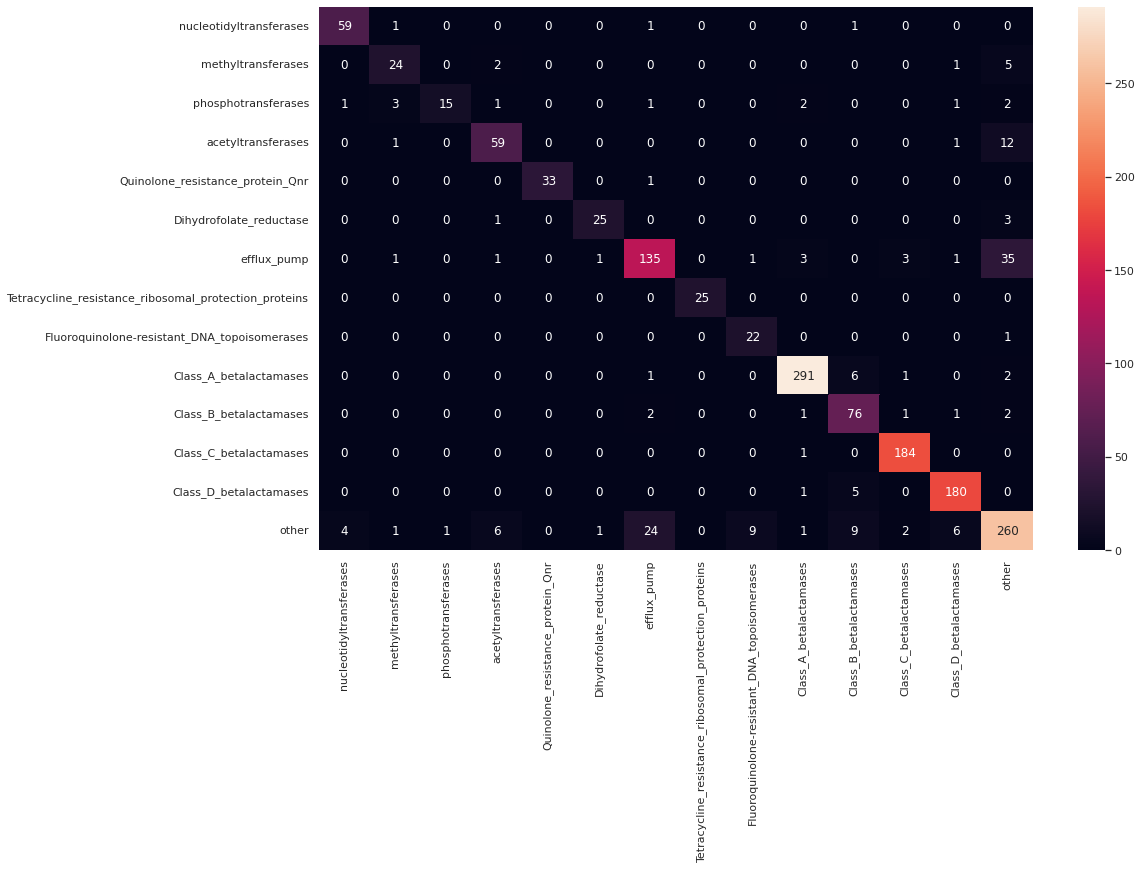

In [58]:
sns.set(rc = {'figure.figsize':(16,10)})
fig, ax = plt.subplots()
sns.heatmap(cmat, annot=cmat, fmt="",  ax=ax, yticklabels=(label_code_2.keys()),
            xticklabels=label_code_2.keys())
plt.show()

In [59]:
model_cut = torch.nn.Sequential(*(list(model.children())[:-1]), model.dense1[:-2])
model_cut

Sequential(
  (0): Embedding(5, 56)
  (1): Conv1d(56, 64, kernel_size=(3,), stride=(1,), padding=same)
  (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (6): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (7): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=14, bias=True)
  )
  (8): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [60]:

embedding_list = []
label_list = []
model_cut.eval() # Set model to evaluation mode 
with torch.no_grad():    
    for batch in train_dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        seq = model_cut[0](seq)

       
        seq = model_cut[1](seq.permute(0, 2, 1))
        seq = model_cut[2:7](seq)
        seq = torch.flatten(seq, 1)
        y_pred = model_cut[7](seq)
        label_list.extend(list(label.squeeze().detach().cpu().numpy()))
        embedding_list.extend(list(y_pred.detach().cpu().numpy()))
        


In [61]:
embedding_list = np.array(embedding_list)
label_list = np.array(label_list)
embedding_list.shape, label_list.shape

((5066, 14), (5066, 2))

In [62]:
label_value = [list(label_code_1.keys())[list(label_code_1.values()).index(p[0])] for p in label_list]

In [63]:
df_embedding = pd.DataFrame(data = (embedding_list))
df_embedding.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,18.225178,0.600649,5.833185,-8.913911,-4.640603,3.459810,-10.302764,-3.106020,-1.274046,1.784204,7.762642,-10.852709,-11.541783,-11.819493
1,5.077901,8.816228,-3.435434,-6.266157,-1.426805,2.535049,-11.594605,-0.588576,0.881742,1.159348,3.729852,-13.674829,-9.676764,-12.652082
2,1.134523,8.206212,-0.343969,-5.601996,-2.375505,2.140489,-7.306730,-4.354628,2.508669,-4.647129,2.242901,-8.289944,-9.546803,-11.597130
3,0.994328,-3.819034,0.176964,-9.768236,12.446000,4.602425,-3.009696,-0.902332,-5.222409,0.803971,6.512626,-24.252386,-18.951494,-21.598358
4,-3.265525,-1.751503,-1.877909,0.854637,1.327834,-3.159704,-8.342969,-0.746823,-7.933345,-6.885264,6.774557,-13.999176,-10.348601,-14.610744


In [64]:
fit = umap.UMAP()
reduced_embedding = fit.fit_transform(df_embedding)

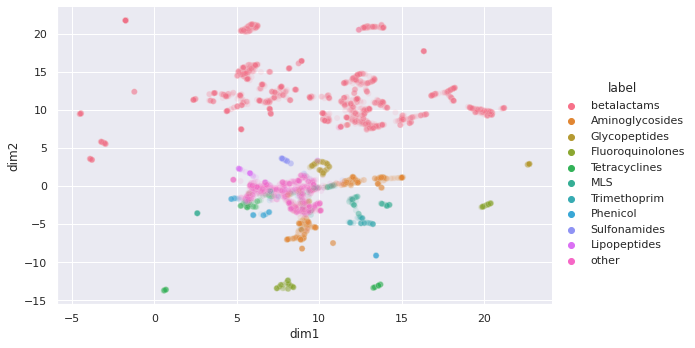

In [65]:
reduced_embedding = pd.DataFrame(reduced_embedding, columns=['dim1', 'dim2'])
reduced_embedding["label"] = np.array(label_value)
sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
                hue='label', hue_order=label_code_1.keys(), aspect=1.61, alpha = 0.1)
plt.show()

In [66]:
model_cut = torch.nn.Sequential(*(list(model.children())[:-1]), model.dense2[:-2])
model_cut

Sequential(
  (0): Embedding(5, 56)
  (1): Conv1d(56, 64, kernel_size=(3,), stride=(1,), padding=same)
  (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (6): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (7): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=14, bias=True)
  )
  (8): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [67]:
# model_cut = nn.Sequential(*[model.children for i in range(1)])
# model_cut
embedding_list = []
label_list = []
model_cut.eval() # Set model to evaluation mode 
with torch.no_grad():    
    for batch in train_dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        seq = model_cut[0](seq)

        # print(x.shape)
        # Apply pooling
        seq = model_cut[1](seq.permute(0, 2, 1))
        seq = model_cut[2:7](seq)
        seq = torch.flatten(seq, 1)
        y_pred = model_cut[7](seq)
        label_list.extend(list(label.squeeze().detach().cpu().numpy()))
        embedding_list.extend(list(y_pred.detach().cpu().numpy()))
        
            # validate your model on each batch here

In [68]:
embedding_list = np.array(embedding_list)
label_list = np.array(label_list)
embedding_list.shape, label_list.shape

((5066, 14), (5066, 2))

In [69]:
label_value1 = [list(label_code_1.keys())[list(label_code_1.values()).index(p[0])] for p in label_list]
label_value2 = [list(label_code_2.keys())[list(label_code_2.values()).index(p[1])] for p in label_list]

In [70]:
df_embedding = pd.DataFrame(data = (embedding_list))
df_embedding.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2.975433,4.219858,0.282622,-3.703919,-2.163585,7.020261,-9.724101,-3.121010,1.992105,-2.234179,3.089003,-6.847527,-7.277231,-8.427832
1,5.428309,0.092966,0.190008,-4.679052,2.776220,1.102099,-8.151155,-4.191390,-0.278077,-0.099726,10.804498,-14.536344,-11.581267,-12.640295
2,22.942055,1.358864,6.850485,-6.596278,-6.827351,3.386593,-14.839617,-3.720541,-3.872358,4.745535,7.726828,-12.435326,-13.630461,-11.223248
3,24.759108,-1.723313,5.443290,-5.935229,-6.075132,-1.031348,-17.495422,-3.444115,-3.960181,8.787818,8.584453,-16.997160,-16.427551,-14.755532
4,21.760126,2.850815,9.319111,-8.269636,-5.951988,6.610736,-14.194607,-6.511481,0.529110,1.877243,7.255079,-15.324156,-15.603447,-13.212578


In [71]:
fit = umap.UMAP()
reduced_embedding = fit.fit_transform(df_embedding)

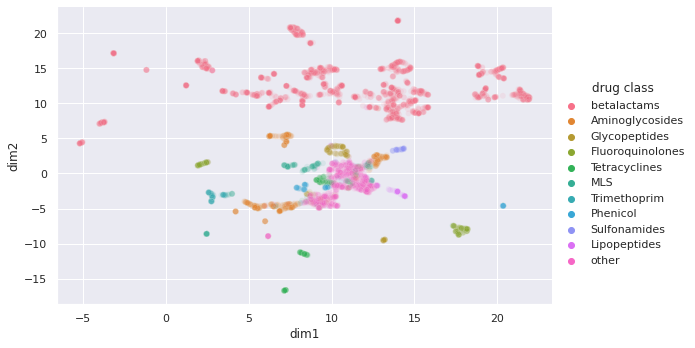

In [72]:
reduced_embedding = pd.DataFrame(reduced_embedding, columns=['dim1', 'dim2'])
reduced_embedding["drug class"] = np.array(label_value1)
reduced_embedding["drug mechanism"] = np.array(label_value2)

sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
                hue='drug class', hue_order=label_code_1.keys(), aspect=1.61, alpha = 0.1)
plt.show()

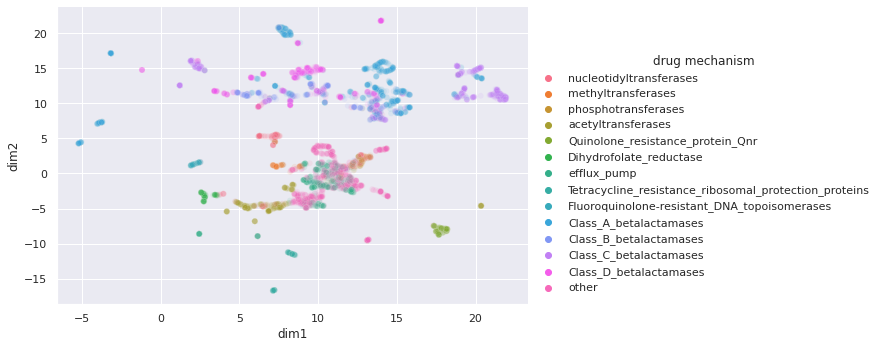

In [73]:
sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
                hue='drug mechanism', hue_order=label_code_2.keys(), aspect=1.61, alpha = 0.1)
plt.show()

## Multitask Model Baseline

In [87]:
class cnn1d_multitask_baseline(nn.Module):
    def __init__(self, label_count1 = len(label_code_1), label_count2 = len(label_code_2)):
        super(cnn1d_multitask_baseline, self).__init__()
        count = 2*(label_count1+label_count2)
        self.embedding = nn.Embedding(5, count)
        
        self.dense1 = nn.Sequential(nn.Linear(count*2000, label_count1))
        self.dense2 = nn.Sequential(nn.Linear(count*2000, label_count2))

    def forward(self, x):
        """Extract first fully connected feature vector"""
        # Apply convolutions
        x = self.embedding(x)
        x = torch.flatten(x, 1)
        x1 = self.dense1(x)
        x2 = self.dense2(x)
        
        return x1, x2

In [88]:
model = cnn1d_multitask_baseline(label_count1=len(label_code_2), label_count2 = len(label_code_2))
model = model.to(device)

In [89]:
print("epoch", "train loss", "validation loss")
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.5*1e-3) 
val_loss_curve = []
train_loss_curve = []

for epoch in range(8):
    
    # Compute train your model on training data
    epoch_loss, train_loss = train_multitask(model, train_dataloader, optimizer,  device=device)
    
    # Validate your on validation data 
    epoch_loss , val_loss = validate_multitask(model, val_dataloader, device=device) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    
    print(epoch, train_loss, val_loss)

epoch train loss validation loss
0 0.7721579 0.5377292
1 0.2059067 0.4288752
2 0.09012158 0.40849414
3 0.042949487 0.46446496
4 0.029427113 0.4305219
5 0.022257257 0.43932706
6 0.017455593 0.46399453
7 0.027116992 0.47813675


In [90]:
pred_labels_class = []
pred_labels_mechanism = []
true_labels_class = []
true_labels_mechanism = []
test_loss = 0
with torch.no_grad():
  model.eval()
  for batch in test_dataloader:
    seq, label = batch
    seq = seq.to(device)
    label = label.to(device)
    logits = model(seq)
    loss1 = nn.functional.cross_entropy(logits[0], label.squeeze()[:, 0])# fill in loss here
    loss2 = nn.functional.cross_entropy(logits[1], label.squeeze()[:, 1])
    loss = (loss1+loss2)/2
    test_loss += loss*len(label)
    preds1 = logits[0].max(1).indices
    preds2 = logits[1].max(1).indices
    true_labels_class.extend(list(label.squeeze().detach().cpu().numpy()[:, 0]))
    true_labels_mechanism.extend(list(label.squeeze().detach().cpu().numpy()[:, 1]))

    pred_labels_class.extend(list(preds1.squeeze().detach().cpu().numpy()))
    pred_labels_mechanism.extend(list(preds2.squeeze().detach().cpu().numpy()))
test_loss = test_loss/len(test_data)
test_loss = test_loss.detach().cpu().numpy()
print("Test loss is {}".format(test_loss))
class_acc = (np.array(true_labels_class) ==  np.array(pred_labels_class)).mean()
mechanism_acc = (np.array(true_labels_mechanism) ==  np.array(pred_labels_mechanism)).mean()

print("Test Acc for Class Prediction is {}".format(class_acc))
print("Test Acc for Mechanism Prediction is {}".format(mechanism_acc))

Test loss is 0.4154670536518097
Test Acc for Class Prediction is 0.9194373401534527
Test Acc for Mechanism Prediction is 0.8797953964194374


In [80]:

# Create dataloaders

In [81]:
# Create model

In [82]:
# Train model

In [83]:
# Test model